# Property–User Matching (Case Study) — End-to-End Baseline (Interview-Grade)

This notebook builds a **hybrid property matching system** using:

- **Users** (`Case Study 2 Data.xlsx`): 25 user preference profiles
- **Properties** (`Case Study 1 Data.xlsx`): 247,172 structured listings

Outputs for each user:
- Top‑K recommended properties
- A **0–100 Match Score**
- An **explainability breakdown** (component contributions)

✅ Runs end‑to‑end.  
✅ Uses embeddings+FAISS if available; otherwise falls back to TF‑IDF.


In [1]:
# 0) Environment setup
import os, re, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import datetime

CURRENT_YEAR = 2026
SEED = 42
np.random.seed(SEED)

USER_XLSX = "/kaggle/input/recommender-system/Case Study 2 Data.xlsx"
PROP_XLSX = "/kaggle/input/recommender-system/Case Study 1 Data.xlsx"

assert os.path.exists(USER_XLSX), f"Missing: {USER_XLSX}"
assert os.path.exists(PROP_XLSX), f"Missing: {PROP_XLSX}"

print("Files found ")
print("User file:", USER_XLSX)
print("Property file:", PROP_XLSX)


Files found 
User file: /kaggle/input/recommender-system/Case Study 2 Data.xlsx
Property file: /kaggle/input/recommender-system/Case Study 1 Data.xlsx


## 1) Load data

- Users: **25 × 5**
- Properties: **247,172 × 10**


In [2]:
users = pd.read_excel(USER_XLSX)
props = pd.read_excel(PROP_XLSX)

print("Users shape:", users.shape)
print("Properties shape:", props.shape)

display(users.head(3))
display(props.head(3))


Users shape: (25, 5)
Properties shape: (247172, 10)


,User ID,Budget,Bedrooms,Bathrooms,Qualitative Description
0,1,$500k,3,2,"""I’ve always dreamed of a modern apartment in ..."
1,2,$300k,2,1,"""I’m looking for a cozy little home where I ca..."
2,3,$700k,4,3,"""My dream home is an eco-friendly sanctuary wi..."


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
0,SI_000001,CityA,3974.0,2.0,2.0,2007.0,Good,Single Family,2020-11-02,324000.0
1,SI_000002,CityA,1660.0,2.0,3.0,1934.0,Good,Single Family,2022-10-23,795000.0
2,SI_000003,CityC,2094.0,2.0,2.0,1950.0,Good,Single Family,2020-11-30,385000.0


## 2) Clean + normalize

Users:
- Parse `Budget` like `"$500k" → 500000`
- Ensure numeric bedrooms/bathrooms

Properties:
- Ensure numeric columns
- Parse dates
- Fill missing values


In [3]:
def parse_budget(x):
    # Parse strings like '$500k' or '$1.2M' into USD float
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace(",", "")
    s = s.replace("$", "")
    m = re.match(r"^([0-9]*\.?[0-9]+)\s*([km])?$", s)
    if not m:
        nums = re.findall(r"[0-9]*\.?[0-9]+", s)
        if not nums:
            return np.nan
        val = float(nums[0])
        if "k" in s:
            return val * 1_000
        if "m" in s:
            return val * 1_000_000
        return val
    val = float(m.group(1))
    unit = m.group(2)
    if unit == "k":
        val *= 1_000
    elif unit == "m":
        val *= 1_000_000
    return val

# --- Users ---
users = users.copy()
users["BudgetUSD"] = users["Budget"].apply(parse_budget)
users["Bedrooms"] = pd.to_numeric(users["Bedrooms"], errors="coerce")
users["Bathrooms"] = pd.to_numeric(users["Bathrooms"], errors="coerce")

# --- Properties ---
props = props.copy()
for c in ["Size","Bedrooms","Bathrooms","Year Built","Price"]:
    props[c] = pd.to_numeric(props[c], errors="coerce")

props["Date Sold"] = pd.to_datetime(props["Date Sold"], errors="coerce")

# Fill missing numeric values with median
for c in ["Bedrooms","Bathrooms","Size","Year Built","Price"]:
    props[c] = props[c].fillna(props[c].median())

# Fill missing categoricals
for c in ["Location","Condition","Type"]:
    props[c] = props[c].fillna("Unknown").astype(str)

display(users.head(2))
display(props.head(2))


,User ID,Budget,Bedrooms,Bathrooms,Qualitative Description,BudgetUSD
0,1,$500k,3,2,"""I’ve always dreamed of a modern apartment in ...",500000.0
1,2,$300k,2,1,"""I’m looking for a cozy little home where I ca...",300000.0


,Property ID,Location,Size,Bedrooms,Bathrooms,Year Built,Condition,Type,Date Sold,Price
0,SI_000001,CityA,3974.0,2.0,2.0,2007.0,Good,Single Family,2020-11-02,324000.0
1,SI_000002,CityA,1660.0,2.0,3.0,1934.0,Good,Single Family,2022-10-23,795000.0


## 3) Feature engineering

- Property **Age** = `CURRENT_YEAR - Year Built`
- Robust size normalization (median/IQR) → `Size01 ∈ [0,1]`
- Build `PropText` for semantic retrieval: Location/Type/Condition/rooms/size/year/price


In [4]:
# Property age
props["Age"] = (CURRENT_YEAR - props["Year Built"]).clip(lower=0)

# Robust normalization for size (median/IQR)
size_med = props["Size"].median()
size_iqr = props["Size"].quantile(0.75) - props["Size"].quantile(0.25)
if size_iqr == 0:
    size_iqr = props["Size"].std() if props["Size"].std() > 0 else 1.0

def robust_size01(size):
    z = np.clip((size - size_med) / size_iqr, -2, 2)
    return (z + 2) / 4

props["Size01"] = props["Size"].apply(robust_size01)

def property_text(row):
    return (
        f"Location {row['Location']} | "
        f"Type {row['Type']} | "
        f"Condition {row['Condition']} | "
        f"{int(row['Bedrooms'])} bedrooms | {int(row['Bathrooms'])} bathrooms | "
        f"Size {int(row['Size'])} sqft | "
        f"Year {int(row['Year Built'])} | "
        f"Price {int(row['Price'])}"
    )

props["PropText"] = props.apply(property_text, axis=1)
props[["Property ID","PropText"]].head()


,Property ID,PropText
0,SI_000001,Location CityA | Type Single Family | Conditio...
1,SI_000002,Location CityA | Type Single Family | Conditio...
2,SI_000003,Location CityC | Type Single Family | Conditio...
3,SI_000004,Location CityB | Type Single Family | Conditio...
4,SI_000005,Location CityB | Type Single Family | Conditio...


## 4) Extract interpretable intent from user text

We infer (lightweight heuristics):
- Preferred `Type` set
- Location intent set (urban/suburban/rural/beachfront)
- `Modernity01` in [0,1]
- `Spacious01` in [0,1]
- Preferred `Condition` set


In [5]:
TYPE_PATTERNS = {
    "Apartment": [r"\bapartment\b", r"\bflat\b"],
    "Condo": [r"\bcondo\b", r"\bcondominium\b"],
    "Single Family": [r"\bfamily home\b", r"\b(single[-\s]?family)\b", r"\bhouse\b", r"\bhome\b"],
    "Townhouse": [r"\btownhouse\b"],
    "Villa": [r"\bvilla\b"],
}

LOC_INTENT = {
    "urban": [r"\bdowntown\b", r"\bheart of the city\b", r"\bcity life\b", r"\burban\b"],
    "suburban": [r"\bsuburb\b", r"\bquiet neighborhood\b", r"\bfamily-friendly\b"],
    "rural": [r"\bcountryside\b", r"\brural\b", r"\bfarm\b", r"\bnature\b"],
    "beachfront": [r"\bbeachfront\b", r"\bbeach\b", r"\bsea\b", r"\bocean\b"],
}

def extract_set(text, pattern_dict):
    t = (text or "").lower()
    out = set()
    for k, pats in pattern_dict.items():
        for p in pats:
            if re.search(p, t):
                out.add(k)
                break
    return out

def extract_modernity(text):
    t = (text or "").lower()
    pos = sum(bool(re.search(p, t)) for p in [r"\bmodern\b", r"\bnew\b", r"\bluxury\b", r"\bsmart\b", r"\bcontemporary\b"])
    neg = sum(bool(re.search(p, t)) for p in [r"\bvintage\b", r"\bhistoric\b", r"\bclassic\b", r"\bold\b"])
    return float(np.clip(0.5 + 0.15*pos - 0.15*neg, 0, 1))

def extract_spaciousness(text):
    t = (text or "").lower()
    pos = sum(bool(re.search(p, t)) for p in [r"\bspacious\b", r"\blarge\b", r"\bbig\b", r"\bopen[-\s]?concept\b", r"\broomy\b"])
    neg = sum(bool(re.search(p, t)) for p in [r"\bcozy\b", r"\bsmall\b", r"\bcompact\b"])
    return float(np.clip(0.5 + 0.15*pos - 0.15*neg, 0, 1))

def extract_condition_pref(text):
    t = (text or "").lower()
    want_new = any(re.search(p, t) for p in [r"\bnew\b", r"\bmove[-\s]?in ready\b", r"\bno repairs\b", r"\brenovated\b"])
    want_fix = any(re.search(p, t) for p in [r"\bfixer\b", r"\brenovation\b", r"\bproject\b", r"\binvestment\b"])
    if want_new and not want_fix:
        return {"New", "Good"}
    if want_fix and not want_new:
        return {"Needs Renovation"}
    return set()

users = users.copy()
users["PrefTypes"] = users["Qualitative Description"].apply(lambda x: extract_set(x, TYPE_PATTERNS))
users["LocIntent"] = users["Qualitative Description"].apply(lambda x: extract_set(x, LOC_INTENT))
users["Modernity01"] = users["Qualitative Description"].apply(extract_modernity)
users["Spacious01"] = users["Qualitative Description"].apply(extract_spaciousness)
users["PrefCond"] = users["Qualitative Description"].apply(extract_condition_pref)

users[["User ID","PrefTypes","LocIntent","Modernity01","Spacious01","PrefCond"]].head()


,User ID,PrefTypes,LocIntent,Modernity01,Spacious01,PrefCond
0,1,{Apartment},{urban},0.65,0.50,{}
1,2,{Single Family},{},0.50,0.35,{}
2,3,{Single Family},{},0.65,0.65,{}
3,4,{Single Family},{},0.65,0.80,{}
4,5,{},{beachfront},0.65,0.50,{}


## 5) Candidate retrieval

We use:
- **Prefilter**: `Price <= 1.10×Budget` and `|Beds - target| <= 2`
- **Semantic retrieval** (optional): SentenceTransformer + FAISS
- Fallback: TF‑IDF cosine similarity


In [6]:
!pip install sentence_transformers

In [7]:
!pip install faiss-gpu-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 42.6 MB/s eta 0:00:00:00:0100:01


In [8]:
USE_EMBEDDINGS = True

try:
    from sentence_transformers import SentenceTransformer
except Exception as e:
    USE_EMBEDDINGS = False
    print("sentence-transformers not available -> TF-IDF fallback")

try:
    import faiss
except Exception as e:
    faiss = None
    print("faiss not available -> TF-IDF or subset cosine fallback")

print("USE_EMBEDDINGS =", USE_EMBEDDINGS)


2026-02-05 06:42:14.432471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770273734.667084      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770273734.737016      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770273735.269126      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770273735.269166      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770273735.269168      55 computation_placer.cc:177] computation placer alr

USE_EMBEDDINGS = True


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

cache_dir = "/mnt/data/cache_case_study"
os.makedirs(cache_dir, exist_ok=True)

prop_embeddings = None
embedder = None
faiss_index = None

TFIDF_READY = False
tfidf_vec = None
tfidf_prop_mat = None

if USE_EMBEDDINGS:
    EMB_MODEL_NAME = "all-mpnet-base-v2"
    prop_emb_path = os.path.join(cache_dir, "prop_embeddings.npy")

    embedder = SentenceTransformer(EMB_MODEL_NAME)

    if os.path.exists(prop_emb_path):
        prop_embeddings = np.load(prop_emb_path)
        print("Loaded cached property embeddings:", prop_embeddings.shape)
    else:
        prop_embeddings = embedder.encode(
            props["PropText"].astype(str).tolist(),
            show_progress_bar=True,
            convert_to_numpy=True,
            batch_size=256,
            normalize_embeddings=True,
        )
        np.save(prop_emb_path, prop_embeddings)
        print("Saved property embeddings:", prop_embeddings.shape)

    if faiss is not None:
        dim = prop_embeddings.shape[1]
        faiss_index = faiss.IndexFlatIP(dim)
        faiss_index.add(prop_embeddings.astype(np.float32))
        print("FAISS index ready:", faiss_index.ntotal)

if (not USE_EMBEDDINGS) or (faiss_index is None):
    tfidf_vec = TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")
    tfidf_prop_mat = tfidf_vec.fit_transform(props["PropText"].astype(str).tolist())
    TFIDF_READY = True
    print("TF-IDF matrix ready:", tfidf_prop_mat.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/966 [00:00<?, ?it/s]

Saved property embeddings: (247172, 768)
FAISS index ready: 247172


In [10]:
def prefilter_props(user_row, price_slack=1.10, bed_slack=2):
    B = float(user_row["BudgetUSD"])
    b = float(user_row["Bedrooms"])
    mask = (props["Price"] <= price_slack * B) & (np.abs(props["Bedrooms"] - b) <= bed_slack)
    idx = np.where(mask.values)[0]
    if idx.size == 0:
        idx = np.arange(len(props))
    return idx

def retrieve_semantic_candidates(user_row, pool_idx, topn=400):
    q = str(user_row["Qualitative Description"])

    if USE_EMBEDDINGS and faiss_index is not None and embedder is not None:
        q_emb = embedder.encode([q], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
        D, I = faiss_index.search(q_emb, 5000)  # wide retrieval then intersect
        hits = I[0]
        pool_set = set(pool_idx.tolist())
        filtered = [i for i in hits if i in pool_set]
        if len(filtered) < topn:
            filtered = filtered + [i for i in pool_idx[:topn] if i not in filtered]
        return np.array(filtered[:topn], dtype=int)

    if TFIDF_READY:
        qv = tfidf_vec.transform([q])
        pool_mat = tfidf_prop_mat[pool_idx]
        sims = cosine_similarity(qv, pool_mat).ravel()
        top_local = np.argsort(-sims)[:topn]
        return pool_idx[top_local]

    return pool_idx[:topn]


## 6) Exact Match Score (0–100)

We implement the hybrid formula (structured + inferred intent) and keep all component scores for explainability.


In [11]:
# Weights (sum to 1)
W = {"price":0.30,"bed":0.18,"bath":0.10,"type":0.12,"cond":0.08,"year":0.07,"size":0.07,"loc":0.08}

def budget_gate(price, budget, alpha=10.0):
    if budget <= 0 or np.isnan(budget):
        return 0.0
    if price <= budget:
        return 1.0
    r = (price - budget) / budget
    return float(np.exp(-alpha * r))

def s_price(price, budget, beta=0.6):
    if budget <= 0 or np.isnan(budget):
        return 0.0
    z = price / budget
    if z > 1:
        return 0.0
    slack = 1 - z
    if slack > beta:
        return 0.0
    return float(1 - (slack / beta) ** 2)

def s_bed(b_p, b_u, sigma=1.0):
    return float(np.exp(-abs(b_p - b_u) / sigma))

def s_bath(t_p, t_u, sigma=1.5):
    return float(np.exp(-abs(t_p - t_u) / sigma))

def s_type(type_p, pref_types, gamma=0.2):
    if not pref_types:
        return 0.5
    return 1.0 if type_p in pref_types else gamma

def s_cond(cond_p, pref_cond, gamma=0.3):
    if not pref_cond:
        return 0.6
    return 1.0 if cond_p in pref_cond else gamma

def s_year(year_built, modernity01, tau=25.0):
    age = max(0.0, CURRENT_YEAR - float(year_built))
    n_p = float(np.exp(-age / tau))  # newness
    return float(1 - abs(n_p - modernity01))

def s_size(size01, spacious01):
    return float(1 - abs(size01 - spacious01))

CITY_INTENT_MAP = {"CityA":"urban","CityB":"suburban","CityC":"rural"}
def s_loc(location_p, loc_intent_set, gamma=0.25):
    if not loc_intent_set:
        return 0.5
    intent = CITY_INTENT_MAP.get(str(location_p), None)
    if intent is None:
        return 0.5
    return 1.0 if intent in loc_intent_set else gamma

def compute_match(user_row, prop_row, alpha=10.0, beta=0.6, sigma_b=1.0, sigma_t=1.5, tau=25.0):
    B = float(user_row["BudgetUSD"])
    price = float(prop_row["Price"])

    g = budget_gate(price, B, alpha=alpha)

    sp = s_price(price, B, beta=beta)
    sb = s_bed(float(prop_row["Bedrooms"]), float(user_row["Bedrooms"]), sigma=sigma_b)
    st = s_bath(float(prop_row["Bathrooms"]), float(user_row["Bathrooms"]), sigma=sigma_t)
    sT = s_type(str(prop_row["Type"]), user_row["PrefTypes"])
    sC = s_cond(str(prop_row["Condition"]), user_row["PrefCond"])
    sY = s_year(float(prop_row["Year Built"]), float(user_row["Modernity01"]), tau=tau)
    sS = s_size(float(prop_row["Size01"]), float(user_row["Spacious01"]))
    sL = s_loc(str(prop_row["Location"]), user_row["LocIntent"])

    weighted_sum = (
        W["price"]*sp + W["bed"]*sb + W["bath"]*st + W["type"]*sT +
        W["cond"]*sC + W["year"]*sY + W["size"]*sS + W["loc"]*sL
    )

    score = float(np.clip(100.0 * g * weighted_sum, 0, 100))

    components = {
        "g_budget": g,
        "s_price": sp, "s_bed": sb, "s_bath": st,
        "s_type": sT, "s_cond": sC, "s_year": sY, "s_size": sS, "s_loc": sL
    }
    contributions = {
        "price": W["price"]*sp,
        "bed":   W["bed"]*sb,
        "bath":  W["bath"]*st,
        "type":  W["type"]*sT,
        "cond":  W["cond"]*sC,
        "year":  W["year"]*sY,
        "size":  W["size"]*sS,
        "loc":   W["loc"]*sL,
    }
    return score, components, contributions


## 7) Generate Top‑10 recommendations for each user


In [12]:
def recommend_for_user(user_row, K=10):
    pool_idx = prefilter_props(user_row, price_slack=1.10, bed_slack=2)
    cand_idx = retrieve_semantic_candidates(user_row, pool_idx, topn=400)

    rows = []
    for i in cand_idx:
        p = props.iloc[i]
        score, comps, contrib = compute_match(user_row, p)
        rows.append({
            "User ID": user_row["User ID"],
            "Property ID": p["Property ID"],
            "Location": p["Location"],
            "Type": p["Type"],
            "Condition": p["Condition"],
            "Bedrooms": float(p["Bedrooms"]),
            "Bathrooms": float(p["Bathrooms"]),
            "Size": float(p["Size"]),
            "Year Built": float(p["Year Built"]),
            "Price": float(p["Price"]),
            "MatchScore": score,
            **comps
        })
    return pd.DataFrame(rows).sort_values("MatchScore", ascending=False).head(K).reset_index(drop=True)

all_recs = []
t0 = time.time()
for _, u in users.iterrows():
    all_recs.append(recommend_for_user(u, K=10))
recs_df = pd.concat(all_recs, ignore_index=True)
print("Done. Total recs:", recs_df.shape, "Time: %.1fs" % (time.time()-t0))
display(recs_df.head(20))


Done. Total recs: (250, 20) Time: 4.4s


,User ID,Property ID,Location,Type,Condition,Bedrooms,Bathrooms,Size,Year Built,Price,MatchScore,g_budget,s_price,s_bed,s_bath,s_type,s_cond,s_year,s_size,s_loc
0,1,CO_057391,CityA,Condominium,Fair,3.0,2.0,2123.0,2019.0,421000.0,84.068536,1.0,0.930656,1.0,1.000000,0.2,0.6,0.894216,0.955622,1.00
1,1,CO_048999,CityA,Condominium,Good,3.0,2.0,1210.0,2023.0,477000.0,84.045262,1.0,0.994122,1.0,1.000000,0.2,0.6,0.763080,0.811434,1.00
2,1,CO_042979,CityA,Condominium,Fair,3.0,2.0,927.0,2022.0,393000.0,80.335843,1.0,0.872789,1.0,1.000000,0.2,0.6,0.797856,0.766740,1.00
3,1,CO_003729,CityC,Condominium,Good,3.0,2.0,2454.0,2019.0,479000.0,80.257239,1.0,0.995100,1.0,1.000000,0.2,0.6,0.894216,0.992104,0.25
4,1,CO_013817,CityA,Condominium,Good,3.0,1.0,2734.0,2021.0,451000.0,79.987909,1.0,0.973322,1.0,0.513417,0.2,0.6,0.831269,0.947884,1.00
5,1,CO_051635,CityD,Condominium,Good,3.0,2.0,1221.0,2023.0,467000.0,79.870755,1.0,0.987900,1.0,1.000000,0.2,0.6,0.763080,0.813171,0.50
6,1,CO_038448,CityA,Condominium,Good,3.0,3.0,1412.0,2022.0,477000.0,79.646179,1.0,0.994122,1.0,0.513417,0.2,0.6,0.797856,0.843335,1.00
7,1,CO_003490,CityC,Condominium,Good,3.0,2.0,2289.0,2014.0,439000.0,79.614018,1.0,0.958656,1.0,1.000000,0.2,0.6,0.968783,0.981838,0.25
8,1,CO_022340,CityC,Condominium,New,3.0,2.0,2153.0,2021.0,469000.0,79.421072,1.0,0.989322,1.0,1.000000,0.2,0.6,0.831269,0.960360,0.25
9,1,CO_021134,CityC,Condominium,Good,3.0,2.0,2907.0,2016.0,436000.0,79.136362,1.0,0.954489,1.0,1.000000,0.2,0.6,0.979680,0.920562,0.25


## 8) Visualizations
- MatchScore histogram
- Best score per user
- Explainability for one example


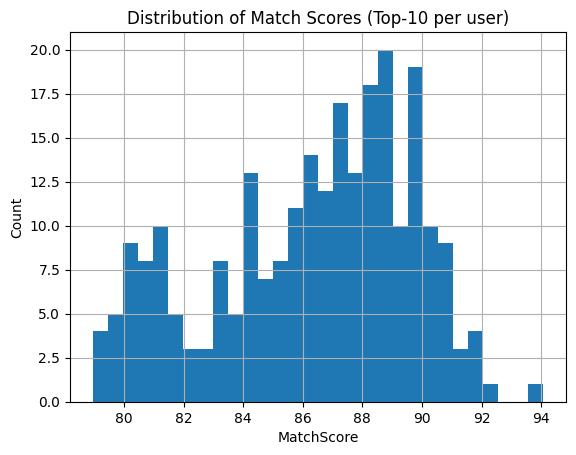

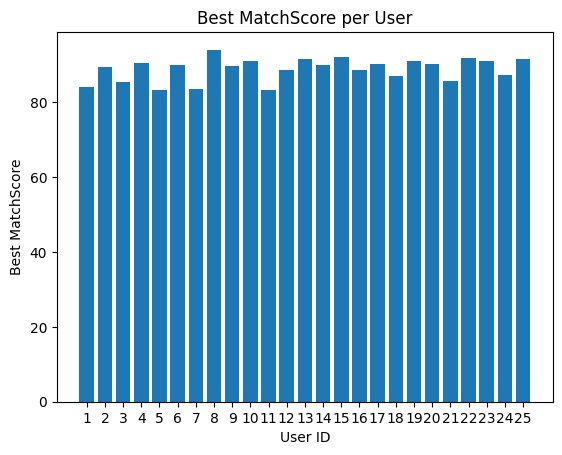

In [13]:
import matplotlib.pyplot as plt

plt.figure()
recs_df["MatchScore"].hist(bins=30)
plt.title("Distribution of Match Scores (Top‑10 per user)")
plt.xlabel("MatchScore")
plt.ylabel("Count")
plt.show()

best = recs_df.groupby("User ID")["MatchScore"].max().reset_index()

plt.figure()
plt.bar(best["User ID"].astype(str), best["MatchScore"])
plt.title("Best MatchScore per User")
plt.xlabel("User ID")
plt.ylabel("Best MatchScore")
plt.show()


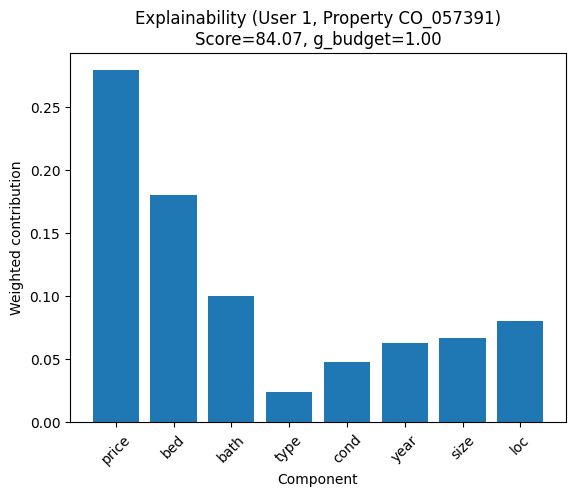

Property ID      CO_057391
Location             CityA
Type           Condominium
Condition             Fair
Bedrooms               3.0
Bathrooms              2.0
Size                2123.0
Year Built          2019.0
Price             421000.0
MatchScore       84.068536
g_budget               1.0
Name: 0, dtype: object

In [14]:
# Explainability breakdown for User 1's top property (change if you want)
example_user_id = int(users["User ID"].iloc[0])
top_row = recs_df[recs_df["User ID"] == example_user_id].sort_values("MatchScore", ascending=False).iloc[0]

score_parts = {
    "price": W["price"] * top_row["s_price"],
    "bed":   W["bed"]   * top_row["s_bed"],
    "bath":  W["bath"]  * top_row["s_bath"],
    "type":  W["type"]  * top_row["s_type"],
    "cond":  W["cond"]  * top_row["s_cond"],
    "year":  W["year"]  * top_row["s_year"],
    "size":  W["size"]  * top_row["s_size"],
    "loc":   W["loc"]   * top_row["s_loc"],
}

plt.figure()
plt.bar(list(score_parts.keys()), list(score_parts.values()))
plt.title(f"Explainability (User {example_user_id}, Property {top_row['Property ID']})\n"
          f"Score={top_row['MatchScore']:.2f}, g_budget={top_row['g_budget']:.2f}")
plt.xlabel("Component")
plt.ylabel("Weighted contribution")
plt.xticks(rotation=45)
plt.show()

display(top_row[["Property ID","Location","Type","Condition","Bedrooms","Bathrooms","Size","Year Built","Price","MatchScore","g_budget"]])


## 9) Export CSV

This CSV is useful for your report/slides and for building a Streamlit/Gradio demo UI.


In [17]:
out_path = "/kaggle/working/match_recommendations_top10_per_user.csv"
recs_df.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: /kaggle/working/match_recommendations_top10_per_user.csv
